## Постановка задачи

Сервис repetit.org служит посредником для репетиторов и клиентов, беря некую долю от денег, заработанных репетиторами. Однако, некоторые репетиторы обманывают сервис, либо не являются достаточно хорошими профессионалами. Задача - создать ML-продукт, который сможет вычислять подобных репетиторов.

## Загрузка данных. Исследовательский анализ данных

Для начала загрузим необходимые мрдули

In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm
from sklearn.utils import resample

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import shap
from sklearn.model_selection import GridSearchCV
from datetime import date

Определим константы.<br> NA_TRESHHOLD - константа, отвечающая за допустимый процент пропусков в данных.
<br>OVERSAMPLING - служит для борьбы с дисбалансом. Значение константы определяет во сколько раз искуственно увеличить целевой класс 
<br>RANDOM_STATE - "зерно" для определения псевдослучайных числе

In [2]:
NA_TRESHHOLD = 0.9
OVERSAMPLING = 3
RANDOM_STATE = 24

Загрузим данные

In [3]:
df_teachers = pd.read_feather("./data/teachers.feather")
df_teacher_prices = pd.read_feather("./data/teacher_prices.feather")
df_orders = pd.read_feather("./data/orders.feather")
df_lesson_course = pd.read_feather("./data/lesson_course.feather")

df_teachers_info = pd.read_feather("./data/teachers_info.feather")

df_lessons = pd.read_feather("./data/lessons.feather")


Инициализируем список всех датасетов для того, чтобы автоматически перебирать их в цикле. Так же, инициализируем список названий наших датасетов.

In [4]:
df_list = [df_teachers, df_teacher_prices, df_orders, df_lesson_course, df_teachers_info, df_lessons] 
df_list_names = ['df_teachers', 'df_teacher_prices', 'df_orders', 'df_lesson_course', 'df_teachers_info', 'df_lessons'] 

Напишем функцию, которая будет выводить график, указывающий процентное соотношение пропусков в датасете.

In [5]:
def rel_na_bar(input_df, #Датасет, который мы исследуем
               df_name = 'default', #Название датасета
               plot_bars = True):#Вычислим процентное соотношение пропусков 
    na_values_percent = (input_df.isna().sum() / len(input_df)).to_frame().rename(columns = {0:'na_values_percent'}).sort_values(by = 'na_values_percent', ascending = False)

#Построим график с процентным соотношением пропусков, либо просто вернём процентное соотношение пропусков
    
    if plot_bars:
        
        na_values_percent.plot.bar(figsize = (12,3), title = df_name )
    else:
        return na_values_percent
    ;

Мы считаем, что те колонки, в которых процент пропусков выше 90% бесполезны. Они будут создавать лишь лишние признаки, которые несут в себе мало полезной информации. Потому избавимся от них.

In [6]:
for i in range(len(df_list)):
    to_drop = list(rel_na_bar(df_list[i], df_list_names[i],False).query('na_values_percent > @NA_TRESHHOLD').index)
    if len(to_drop) > 0:
        df_list[i] = df_list[i].drop(columns = to_drop)
       

Построим графики процентного соотношения пропусков для наших датасетов

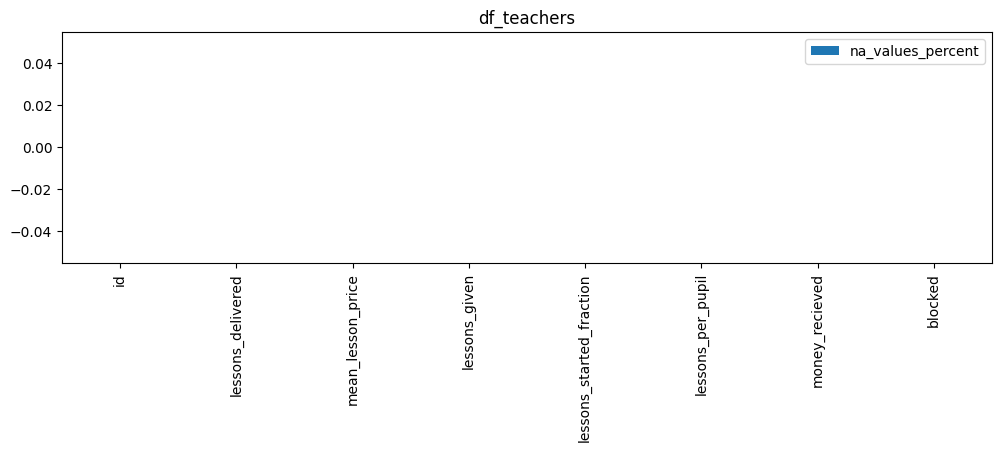

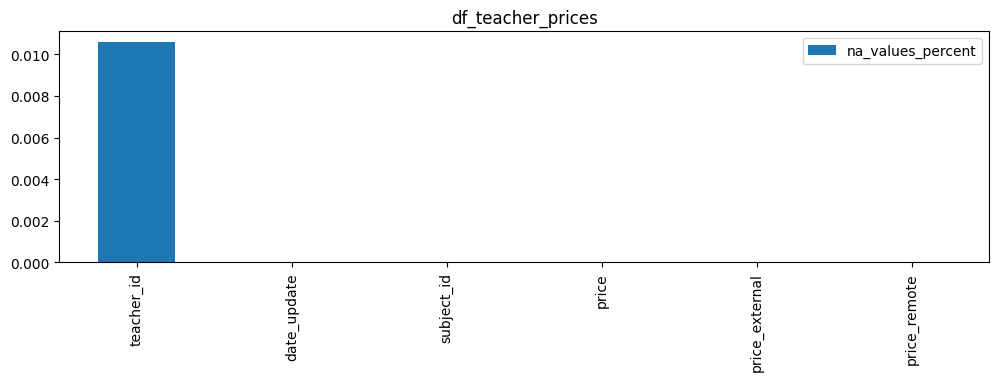

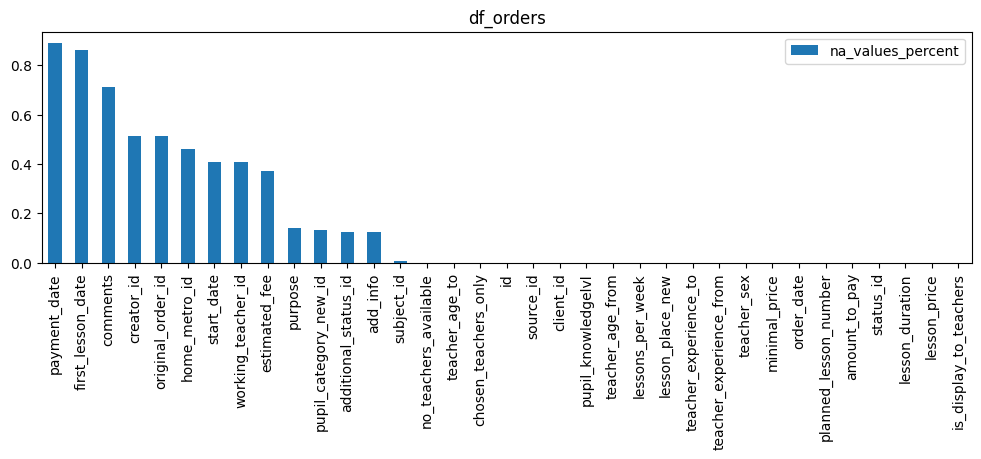

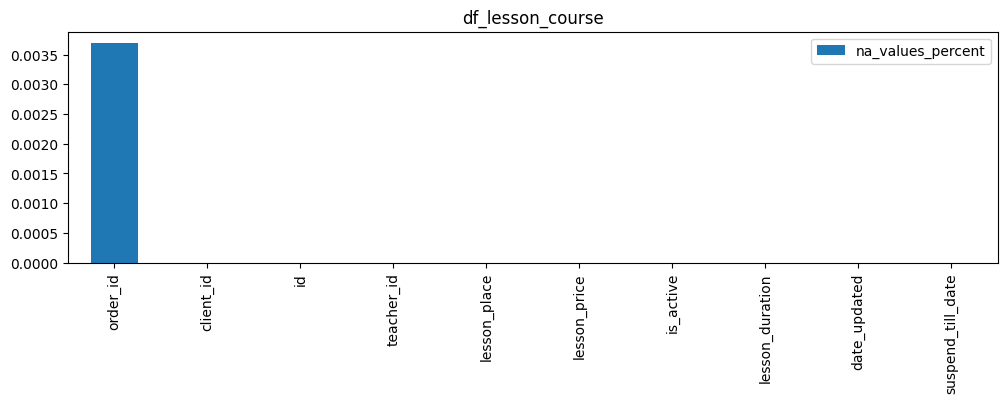

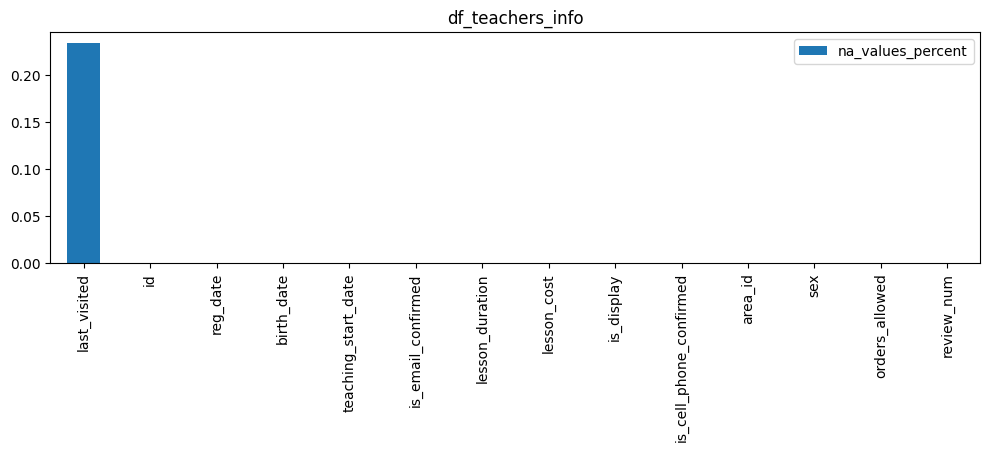

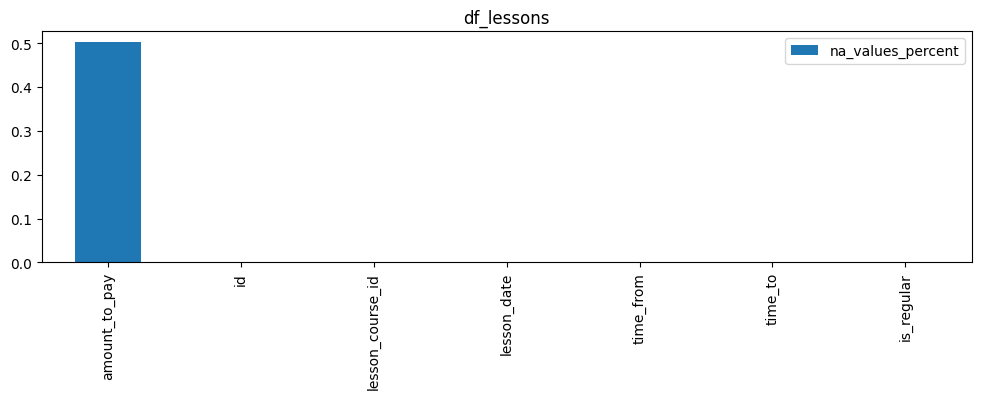

In [7]:

    
for i in range(len(df_list)):
    rel_na_bar(df_list[i],df_list_names[i], plot_bars = True)
        
# Так же сразу удалим данные, вызывающие утечку        
df_teachers_info = df_teachers_info.drop(columns='orders_allowed') 

Мы видим, что в датасете df_teachers нет пропусков. Количество пропусков в остальных датасетах приемлемо. Больше всего пропусков в датасете df_orders, однако этот датасет не будет использован в конечном итоге.
Теперь посмотрим на содержание наших датасетов. Для этого будем использовать функцию head.

In [8]:

for i in range(len(df_list)):
    print(df_list_names[i],df_list[i].shape)
    display(df_list[i].head(3))

df_teachers (1656, 8)


,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0


df_teacher_prices (432422, 6)


,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000


df_orders (1191861, 35)


,id,order_date,subject_id,purpose,lesson_price,lesson_duration,home_metro_id,add_info,start_date,working_teacher_id,...,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,NaN,None,None,NaN,...,0,0,0,18,2294000.0,675960,7.0,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,NaN,None,None,NaN,...,0,0,0,18,2294000.0,675960,7.0,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,143480.0,...,0,0,0,23,NaN,1024439,10.0,1200,None,1


df_lesson_course (893438, 10)


,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940


df_teachers_info (307972, 14)


,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,0,1,2,1,0


df_lessons (1191127, 7)


,id,lesson_course_id,lesson_date,time_from,time_to,is_regular,amount_to_pay
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,1,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,0,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,0,NaN


Мы увидели структуру данных в датасетах. Мы не будем использовать все данные, потому дальнейший анализ мы проведём лишь с теми данными, что войдут в финальный датасет. Перед этим нам следует объединить данные.

In [9]:
#Для начала удалим те датасеты, которые нам не понадобятся из памяти
del df_teacher_prices
del df_orders

In [10]:
#Для начала объединим df_lessons и df_lesson_course
df_lessons = df_lessons.rename(columns = {'lesson_course_id' : 'client_id'}) 
df_plesson = df_lessons.merge(df_lesson_course, on = 'client_id')


In [11]:
#Выбирем  те столбцы в объединённом датасете, которые будем использовать
df_plesson_2 = df_plesson[['teacher_id','is_regular','amount_to_pay', 'amount_paid', 'lesson_price','lesson_duration']]
df_plesson_2 = df_plesson_2.rename(columns = {'teacher_id':'id'})
#Сгруппируем получившийся результат по id
df_plesson_2 = df_plesson_2.groupby(by = 'id').mean()

Теперь обработаем df_teachers_info. Нужно перевести даты в формат, который подходит для обучения модели

In [12]:
#Поменяем типы данных
df_teachers_info['reg_date'] = pd.to_datetime(df_teachers_info['reg_date'], errors="coerce")
df_teachers_info['birth_date'] = pd.to_datetime(df_teachers_info['birth_date'], errors="coerce")
df_teachers_info['teaching_start_date'] = pd.to_datetime(df_teachers_info['teaching_start_date'], errors="coerce")

#Переводим даты в числа. Мы используем не момент "сейчас", а отсчитываем дату от некого момента в будущем, чтобы данные не менялись по ходу работы над проектом
df_teachers_info["age"] = (pd.to_datetime("2025-03-01 00:00:00.000")  - df_teachers_info["birth_date"]) . dt . days / 365
df_teachers_info["reg_years"] = (pd.to_datetime("2025-03-01 00:00:00.000")  - df_teachers_info["reg_date"]) . dt . days / 365
df_teachers_info["stage"] = (pd.to_datetime("2025-03-01 00:00:00.000")  - df_teachers_info["teaching_start_date"]) . dt . days / 365

#Удалим ненужные столбцы
df_teachers_info = df_teachers_info.drop(columns = ['reg_date', 'birth_date', 'teaching_start_date', 'last_visited'])

Теперь создадим финальный датасет

In [13]:
df = df_teachers.merge(df_teachers_info, on = 'id')
df = df.merge(df_plesson_2, on = 'id')

Для дальнейшей работы нам понадобится удалить пропуски. Перед этим используем пропуски для того, чтобы создать новый признак

In [14]:
df['isna'] = df.isnull().sum (axis= 1 )
df = df.drop(columns = 'id')
#Заполняем пропуски минус единицами. Скорее всего, финальная модель будет древовидной, так что это допустимый вариант
df = df.fillna(value= -1)


Переименуем целевую переменную

In [15]:
df = df.rename(columns = {'blocked':'target'})

### Вывод
Мы объединили наши данные и создали финальный датасет, который, в принципе, готов для обучения моделей. Однако перед тем как обучать модель, нам нужно ещё рассмотреть этот датасет и также создать дополнительные признаки.
Также, мы уже создали один такой признак - количество пропусков в каждой строке. Этот признак также оказывает положительное влияние на модель.

## Анализ данных

In [16]:
df.head()

,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,target,is_email_confirmed,lesson_duration_x,lesson_cost,...,review_num,age,reg_years,stage,is_regular,amount_to_pay,amount_paid,lesson_price,lesson_duration_y,isna
0,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,0,60,800,...,10,27.893151,4.906849,7.501370,0.000000,1600.000000,-1.0,1150.000000,60.000000,2
1,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,0,60,600,...,26,57.013699,6.367123,39.523288,0.304183,585.714286,-1.0,926.806084,57.319392,2
2,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,0,60,2500,...,64,59.904110,12.449315,22.512329,0.500000,1010.000000,-1.0,2175.000000,60.000000,2
3,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,0,60,1500,...,10,38.843836,7.484932,19.509589,0.000000,1002.702703,-1.0,1754.347826,62.608696,2
4,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,0,45,1178,...,1,51.495890,2.115068,32.517808,0.100000,1466.666667,-1.0,1357.800000,58.500000,2


<Axes: >

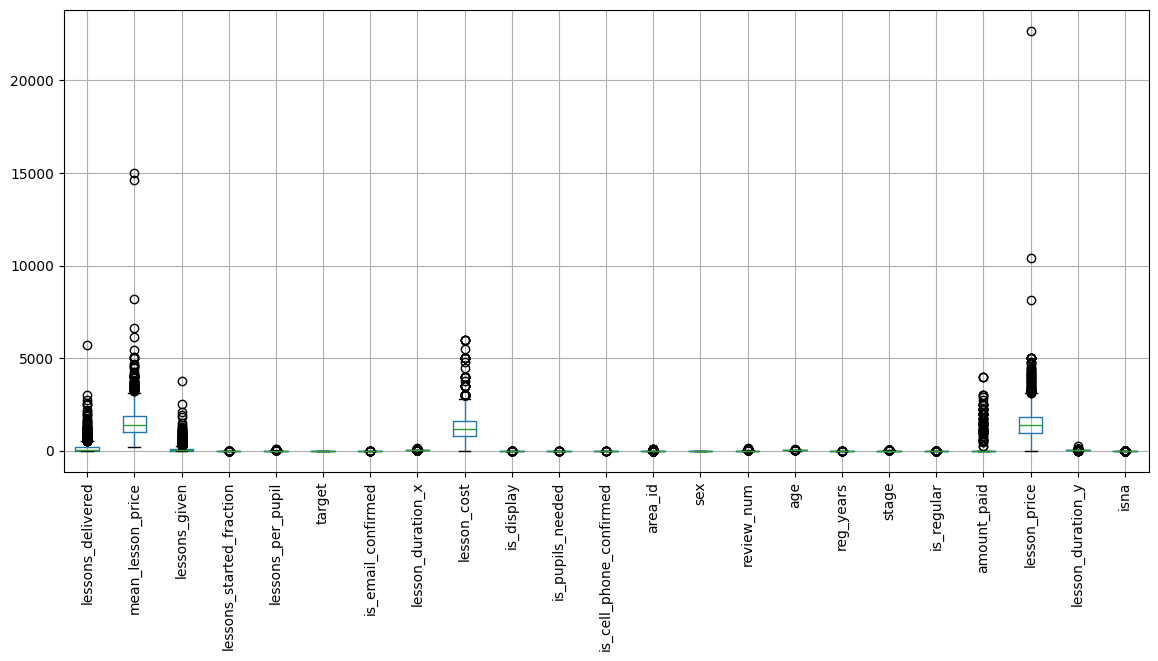

In [17]:
df.drop(columns = ['money_recieved','amount_to_pay']).boxplot(figsize = (14,6), rot = 90)

1155    100000.000000
1455      8494.890511
157       5175.000000
113       5000.000000
665       4257.166667
Name: amount_to_pay, dtype: float64

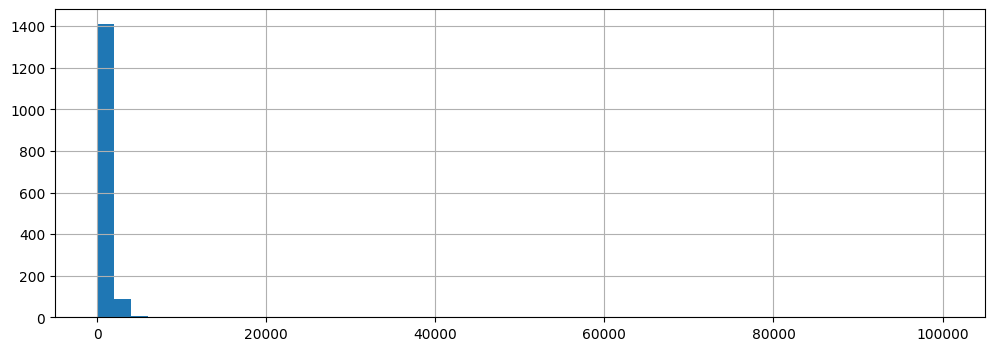

In [18]:
df['amount_to_pay'].hist(bins = 50, figsize = (12,4))
df['amount_to_pay'].sort_values(ascending = False).head()

244    11162200.0
73      5626975.0
9       5367500.0
298     4883290.0
182     4644275.0
Name: money_recieved, dtype: float64

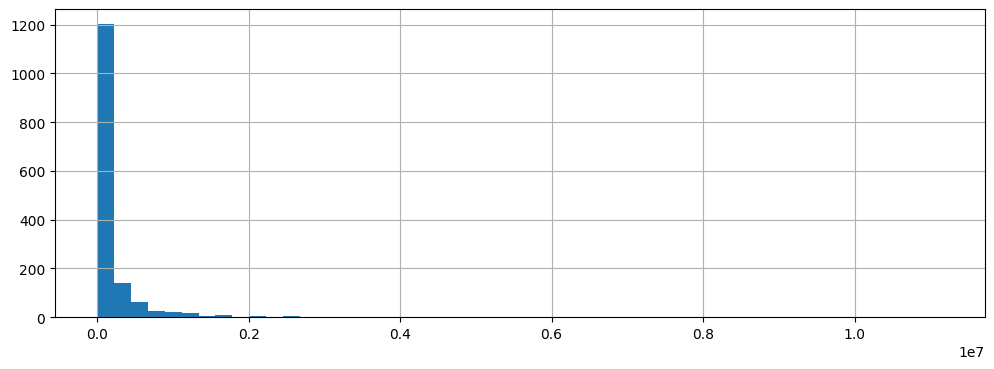

In [19]:
df['money_recieved'].hist(bins = 50, figsize = (12,4))
df['money_recieved'].sort_values(ascending = False).head()

Мы видим выбросы в колонках lessons_delivered, mean_lesson_price, lesson_cost, amount_paid, lesson_price. В колонках money_recieved, amount_to_pay наблюдаются огромные выбросы. Тем не менее, было решено пока не удалять эти выбросы, поскольку само их наличие может нести важную информацию. Также выше было рассмотрено общее количество пропусков в данных.

### Вывод
Данные имеют проблемы - большое количество пропусков в некоторых столбцах, выбросы. Тем не менее, в целом данные вполне можно использовать для обучения модели. Также было замечено, что качество данных в разных датафреймах разное.


## Создание новых признаков

Для начала создадим бинарный признак, указывающий на то, проводит ли репетитор больше одного урока или нет

In [20]:
df['few_lessons'] = df['lessons_per_pupil'].apply(lambda x: 1 if x < 2 else 0)
df['few_lessons'].head()

0    0
1    0
2    0
3    0
4    0
Name: few_lessons, dtype: int64

Для дальнейшей генерации признаков нам понадобится разделить выборку на обучающую и тестовую

In [21]:
y = df['target']
X = df.drop(columns = ['target'])


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Мы успешно разделили выборку. Теперь посмотрим на баланс классов.

In [23]:
df.target.mean()

0.3601328903654485

Мы видим явный дисбаланс. Избавимся от дисбаланса на тренировочной выборке. Путём эксперимента было обнаружено, что лучше всего создать искуственный дисбаланс, но в другую сторону.

In [24]:
resampled_train = X_train.merge(y_train, left_index = True, right_index=True)
upsampled_train = resampled_train[resampled_train["target"] == 1]
upsampled_train = resample(upsampled_train,
             replace=True,
             n_samples=len(resampled_train[resampled_train["target"] == 0])*OVERSAMPLING, #Здесь мы как раз и добавляем искуственный дисбаланс
             random_state=42)


resampled_train = pd.concat([upsampled_train,  resampled_train[resampled_train["target"] == 0]])
del upsampled_train
X_train = resampled_train.drop(columns = 'target')
y_train = resampled_train['target']

In [25]:
y_train.mean()

0.75

Мы справились с дисбалансом классов.

### Использование выбросов как признака

Мы можем использовать количество выбросов в каждой строке как признак. Мы будем определять выбросы только на обучающей выборке, т.е. выбросом будет считаться то, что считается выбросом именно в обучающей выборке, иначе возможна утечка.

Сначала высчитаем необходимые числа, которые мы сможем использовать для определения выбросов в дальнейшем.

In [26]:
#Инициализируем список медианных абсолютных отклонений
median_abs_deviation_list = []
#Инициализируем список признаков, которые мы будем исследовать на выбросы.
num_cols = []
#Инициализируем список медиан для каждого признака
median_list = []

#Автоматичски определим признаки, с которыми мы будем работать
for i in X_train.columns:
    if len(X_train[i].unique()) > 10:
        num_cols.append(i)

#Уберём из них те, которые имеют много уникальных значений, но не подходят нам
#num_cols.remove('home_metro_id')
#num_cols.remove('creator_id')


#Теперь посчитаем медианы и средние медианные отклонения для исследуемых признаков
for i in num_cols:
    vals = X_train[i]
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()

    median_list.append(vals.median())
    median_abs_deviation_list.append(median_abs_deviation)

Теперь мы напишем функцию, которая будет определять, является ли значение выбросом. Для этого будем использовать критерий Хампеля

In [27]:
#Напишем функцию, которая будет определять выбросы для каждого столбца. 
def hampel(
        vals_orig, #Столбец, который мы изучаем
        median_abs_deviation, #среднее медианное отклонение, которое мы выдадим функции из списка
        median_ #сама медиана
        ):
    
    vals = vals_orig.copy()
    #Считаем разницу между реальным значением и средним медианным отклонением
    difference = np.abs(median_-vals)    
    #Определяем порог, при котором будем считать, что данное значение является признаком
    threshold = 3 * median_abs_deviation
    outlier_idx = difference > threshold
    norm_idx = difference <= threshold
    #Присваиваем единицы выбросам и нули нормальным данным
    vals[norm_idx] = 0
    vals[outlier_idx] = 1

    #В качестве результата возвращаем Series
    return(vals)

Применем нашу функцию и создадим новый признак ejection, который будет указывать на то, сколько выбросов в данной строке

In [28]:
#Инициализируем признак для обучающей и тестовой выборок
X_train['ejection'] = 0
X_test['ejection'] = 0

#Перебираем наши столбцы
for i in tqdm(range(len(num_cols))):
#Инициализируем временную колонку с результатами функции. Это нужно, чтобы прибавлять её к нашей колонке с новым признаком. По ходу цикла временная колока будет меняться и эти изменения прибавляться к нашей
    X_train['temporal_column'] = hampel(X_train[num_cols[i]], median_abs_deviation_list[i],median_list[i])
    X_train['ejection'] = X_train[['ejection', 'temporal_column']].sum(axis=1)

    X_test['temporal_column'] = hampel(X_test[num_cols[i]], median_abs_deviation_list[i],median_list[i])
    X_test['ejection'] = X_test[['ejection', 'temporal_column']].sum(axis=1)

#Удаляем временные колонки
X_train = X_train.drop(columns = 'temporal_column')
X_test = X_test.drop(columns = 'temporal_column')

  0%|          | 0/17 [00:00<?, ?it/s]

### Признак, основанный на категориальных переменных

Мы создадим новый признак, основанный на категориальных признаках. По сути, это будет новый вид кодирования: мы возьмём для каждой конкретной категории каждого признака среднее значение целевого признака, затем создадим столбец для каждого категориального признака с соответсвующими значениями. Сами категориальные признаки тоже оставим. Определять нужные значения мы будем только на обучающей выборке, чтобы не было утечки данных.

Для начала создадим список категориальных, но не бинарных признаков.

In [29]:
#Определяем те признаки, которые мы будем использовать, исключая из них бинарные признаки
cat_columns = []
for i in X_train.columns:
    if 2 < len(X_train[i].unique()) <= 11:
        cat_columns.append(i)

Теперь нам нужно создать словарь словарей. В нём будут находиться словари, в которых будут пары значений категориального признака и среднего значения целевого.

In [30]:
#Для начала создаём временный датасет, в котором будут и признаки и целевые переменные, но только для обучающей выборки.
Train = X_train.copy()
Train['target'] = y_train

#Инициализируем словарь словарей, в котором ключами будут служить названия признаков, а значениями словари, в которых в свою очередь ключами будут служить уникальные значения признаков
#А значениями - средний показатель целевого признака для данного значения данного признака
dict_of_dict = {}
#Проходим циклом по нашим признакам
for iterator in tqdm(range(len(cat_columns))):
    i = cat_columns[iterator]
    #Инициализируем словарь, который будет значением словаря словарей
    dict = {}
    #Проходим циклом по уникальным значениям нашего признака
    for e in Train[i].unique():
        query_str = i + '==' + str(e)
        #Считаем среднее целевой переменной только по тем строкам данных, которые удовлетворяют условию, которое заключается в том, что соотвествующий признак равен соответсвующему значению. 
        dict[e] =  Train.query(query_str)['target'].mean()
    #Добавляем получившийся словарь в словарь словарей
    dict_of_dict[i] = dict

#Посмотрим на результат
dict_of_dict

  0%|          | 0/3 [00:00<?, ?it/s]

{'lesson_duration_x': {30: 0.6666666666666666,
  60: 0.7510389119758217,
  90: 0.7613636363636364,
  45: 0.7150259067357513,
  160: 1.0,
  50: 0.7884615384615384,
  55: 0.9047619047619048,
  40: 0.7931034482758621,
  120: 0.0,
  80: 0.0},
 'is_pupils_needed': {-1.0: 0.7516469038208169,
  1.0: 0.6578947368421053,
  0.0: 0.5},
 'isna': {2: 0.7554585152838428,
  1: 0.7169811320754716,
  3: 0.7282229965156795,
  0: 0.8888888888888888}}

Словарь успешно создан, теперь нужно создать сам признак.

In [31]:
# Проходим циклу по нашим признакам
for i in tqdm(range(len(cat_columns))):
    #Генерируем название нового столбца
    column_name = cat_columns[i]
    new_column_name = column_name + '__mean_target'
    #Вытаскиваем нужный словарь из словаря словарей для каждого признака
    replace_dict = dict_of_dict[column_name]
    #Создаём новые столбцы, которые содержат полученные значения для обучающей и тестовой выборок. Но так как мы считали значения только на обучающей, утечки данных нет.
    X_train[new_column_name] = X_train[column_name].replace(replace_dict)
    X_test[new_column_name] = X_test[column_name].replace(replace_dict)

#### Ниже под коммнтариями находятся строки кода, которые должны были избавиться от оригинальных категориальных столбцов. Однако, практика показала, что имеет смысл оставлять как старые, так и новые столбцы.
#X_train = X_train.drop(columns = cat_columns)
#X_test = X_test.drop(columns = cat_columns)

X_train.head(5)

  0%|          | 0/3 [00:00<?, ?it/s]

,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,is_email_confirmed,lesson_duration_x,lesson_cost,is_display,...,amount_to_pay,amount_paid,lesson_price,lesson_duration_y,isna,few_lessons,ejection,lesson_duration_x__mean_target,is_pupils_needed__mean_target,isna__mean_target
570,477.0,351.264706,476.0,0.239583,10.347826,167202.0,0,30,350,1,...,919.153846,-1.0,599.333333,53.600000,2,0,6.0,0.666667,0.751647,0.755459
1122,26.0,2855.555556,18.0,0.040650,3.600000,51400.0,0,60,2500,1,...,916.269841,-1.0,2563.857678,60.842697,2,0,6.0,0.751039,0.751647,0.755459
738,9.0,950.000000,8.0,0.058824,8.000000,7600.0,0,90,2000,1,...,1000.000000,-1.0,800.000000,60.000000,2,0,0.0,0.761364,0.751647,0.755459
375,266.0,935.294118,85.0,0.285714,14.166667,79500.0,0,60,2000,1,...,1992.073171,-1.0,1362.068966,44.137931,2,0,3.0,0.751039,0.751647,0.755459
291,978.0,1047.619048,420.0,0.229358,16.800000,440000.0,0,60,1000,1,...,749.166667,1000.0,1025.837321,62.009569,1,0,6.0,0.751039,0.751647,0.716981


Мы видим, что наш признак успешно создан.

### Вывод

Мы создали несколько признаков. Во время работы над проектом предпринимались попытки создать и другие признаки, но они ухудшили показатели модели.

## Обучение модели и финальный отбор признаков

Для начала напишем функцию, которая выведет метрики модели.

In [32]:
#Напишем функцию, которая будет выводить метрики модели
def scoring():
    print('f1', f1_score(y_test, pred))
    print('accuracy', accuracy_score(y_test, pred))
    print('recall_score', recall_score(y_test, pred))
    print('precision_score', precision_score(y_test, pred))
    print('roc_auc_score', roc_auc_score(y_test, pred))

Инициализируем список для дальнейшего анализа моделей

In [33]:
best_model = []

### Выбор модели

Мы обучим несколько моделей используя GreedSearch. 

In [34]:
#Инициализируем модель
model = CatBoostClassifier()

#Инициализируем параметры для GridSearchCV
parameters = {'depth'         : [ 5,8],
                 'learning_rate' : [0.3, 0.5, 0.8, 1],
                  'iterations'    : [1000],
                  'silent': [True],
                  'random_seed':[RANDOM_STATE],
                  'grow_policy':['SymmetricTree', 'Depthwise', 'Lossguide']
                  
                 }
#Ищем лучшие гиперпараметры для обучающей выборки
Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, verbose = 3, scoring='f1')
Grid_CBC.fit(X_train, y_train, plot=False)

#Запоминаем параметры модели. Мы не будем использовать именно эту модель, так что нам важны именно параметры.
params = Grid_CBC.best_params_

#Выводим результаты
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

best_model.append([Grid_CBC.best_estimator_,Grid_CBC.best_params_, Grid_CBC.best_score_])

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2] END depth=5, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.3, random_seed=24, silent=True;, score=0.922 total time=   2.3s
[CV 2/2] END depth=5, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.3, random_seed=24, silent=True;, score=0.928 total time=   2.2s
[CV 1/2] END depth=5, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.5, random_seed=24, silent=True;, score=0.921 total time=   2.0s
[CV 2/2] END depth=5, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.5, random_seed=24, silent=True;, score=0.924 total time=   2.1s
[CV 1/2] END depth=5, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.8, random_seed=24, silent=True;, score=0.919 total time=   2.2s
[CV 2/2] END depth=5, grow_policy=SymmetricTree, iterations=1000, learning_rate=0.8, random_seed=24, silent=True;, score=0.928 total time=   2.3s
[CV 1/2] END depth=5, grow_policy=SymmetricTree, iterations=100

In [35]:
#Инициализируем модель
model = LogisticRegression()

#Инициализируем параметры для GridSearchCV
parameters = {'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}
#Ищем лучшие гиперпараметры для обучающей выборки
Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, verbose = 3, scoring='f1')
Grid_CBC.fit(X_train, y_train)

#Запоминаем параметры модели. Мы не будем использовать именно эту модель, так что нам важны именно параметры.
params = Grid_CBC.best_params_

#Выводим результаты
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

best_model.append([Grid_CBC.best_estimator_,Grid_CBC.best_params_, Grid_CBC.best_score_])

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END ......................solver=lbfgs;, score=0.867 total time=   0.0s
[CV 2/2] END ......................solver=lbfgs;, score=0.869 total time=   0.0s
[CV 1/2] END ..................solver=liblinear;, score=0.874 total time=   0.0s
[CV 2/2] END ..................solver=liblinear;, score=0.875 total time=   0.0s


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
newton-cg failed to converge. Increase the number of iterations.


[CV 1/2] END ..................solver=newton-cg;, score=0.872 total time=   0.3s


The line search algorithm did not converge
The line search algorithm did not converge
newton-cg failed to converge. Increase the number of iterations.
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


[CV 2/2] END ..................solver=newton-cg;, score=0.873 total time=   0.4s
[CV 1/2] END ............solver=newton-cholesky;, score=0.867 total time=   0.0s
[CV 2/2] END ............solver=newton-cholesky;, score=0.874 total time=   0.0s
[CV 1/2] END ........................solver=sag;, score=0.816 total time=   0.0s
[CV 2/2] END ........................solver=sag;, score=0.828 total time=   0.0s
[CV 1/2] END .......................solver=saga;, score=0.743 total time=   0.0s
[CV 2/2] END .......................solver=saga;, score=0.788 total time=   0.0s
 Results from Grid Search 

 The best estimator across ALL searched params:
 LogisticRegression(solver='liblinear')

 The best score across ALL searched params:
 0.8745389635060341

 The best parameters across ALL searched params:
 {'solver': 'liblinear'}


The max_iter was reached which means the coef_ did not converge


In [36]:
#Инициализируем модель
model = DecisionTreeClassifier()

#Инициализируем параметры для GridSearchCV
parameters = {'max_depth':[2,10,20,30], 'min_samples_leaf':[2,10,20,30]
}
#Ищем лучшие гиперпараметры для обучающей выборки
Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, verbose = 3, scoring='f1')
Grid_CBC.fit(X_train, y_train)

#Запоминаем параметры модели. Мы не будем использовать именно эту модель, так что нам важны именно параметры.
params = Grid_CBC.best_params_

#Выводим результаты
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

best_model.append([Grid_CBC.best_estimator_,Grid_CBC.best_params_, Grid_CBC.best_score_])

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2] END ...max_depth=2, min_samples_leaf=2;, score=0.869 total time=   0.0s
[CV 2/2] END ...max_depth=2, min_samples_leaf=2;, score=0.838 total time=   0.0s
[CV 1/2] END ..max_depth=2, min_samples_leaf=10;, score=0.869 total time=   0.0s
[CV 2/2] END ..max_depth=2, min_samples_leaf=10;, score=0.838 total time=   0.0s
[CV 1/2] END ..max_depth=2, min_samples_leaf=20;, score=0.869 total time=   0.0s
[CV 2/2] END ..max_depth=2, min_samples_leaf=20;, score=0.838 total time=   0.0s
[CV 1/2] END ..max_depth=2, min_samples_leaf=30;, score=0.869 total time=   0.0s
[CV 2/2] END ..max_depth=2, min_samples_leaf=30;, score=0.838 total time=   0.0s
[CV 1/2] END ..max_depth=10, min_samples_leaf=2;, score=0.902 total time=   0.0s
[CV 2/2] END ..max_depth=10, min_samples_leaf=2;, score=0.893 total time=   0.0s
[CV 1/2] END .max_depth=10, min_samples_leaf=10;, score=0.875 total time=   0.0s
[CV 2/2] END .max_depth=10, min_samples_leaf=10;

In [37]:
#Инициализируем модель
model = RandomForestClassifier()

#Инициализируем параметры для GridSearchCV
parameters = {'max_depth':[2,10,20,30], 'min_samples_leaf':[2,10,20,30], 'n_estimators': [10,50 ,100,200], 'random_state' : [RANDOM_STATE]
}
#Ищем лучшие гиперпараметры для обучающей выборки
Grid_CBC = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, verbose = 3, scoring='f1')
Grid_CBC.fit(X_train, y_train)

#Запоминаем параметры модели. Мы не будем использовать именно эту модель, так что нам важны именно параметры.
params = Grid_CBC.best_params_

#Выводим результаты
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

best_model.append([Grid_CBC.best_estimator_,Grid_CBC.best_params_, Grid_CBC.best_score_])

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[CV 1/2] END max_depth=2, min_samples_leaf=2, n_estimators=10, random_state=24;, score=0.871 total time=   0.0s
[CV 2/2] END max_depth=2, min_samples_leaf=2, n_estimators=10, random_state=24;, score=0.873 total time=   0.0s
[CV 1/2] END max_depth=2, min_samples_leaf=2, n_estimators=50, random_state=24;, score=0.870 total time=   0.0s
[CV 2/2] END max_depth=2, min_samples_leaf=2, n_estimators=50, random_state=24;, score=0.872 total time=   0.0s
[CV 1/2] END max_depth=2, min_samples_leaf=2, n_estimators=100, random_state=24;, score=0.872 total time=   0.1s
[CV 2/2] END max_depth=2, min_samples_leaf=2, n_estimators=100, random_state=24;, score=0.873 total time=   0.1s
[CV 1/2] END max_depth=2, min_samples_leaf=2, n_estimators=200, random_state=24;, score=0.873 total time=   0.2s
[CV 2/2] END max_depth=2, min_samples_leaf=2, n_estimators=200, random_state=24;, score=0.873 total time=   0.3s
[CV 1/2] END max_depth=2, min_samples_

Мы обучили несколько моделей, теперь сравним их.

In [38]:
bm = pd.DataFrame(best_model, columns = ['bm','est','score'])
bm

,bm,est,score
0,<catboost.core.CatBoostClassifier object at 0x...,"{'depth': 5, 'grow_policy': 'Lossguide', 'iter...",0.928937
1,LogisticRegression(solver='liblinear'),{'solver': 'liblinear'},0.874539
2,"DecisionTreeClassifier(max_depth=20, min_sampl...","{'max_depth': 20, 'min_samples_leaf': 2}",0.902966
3,"(DecisionTreeClassifier(max_depth=30, max_feat...","{'max_depth': 30, 'min_samples_leaf': 2, 'n_es...",0.915865


Мы обучили и подобрали параметры для следующих моделей: CatBoost, LogisticRegression, Дерево Решений и Случайный Лес. Лучший показатель целевой метрики (f1) у CatBoost, однако, было принято решение использовать более простую модель - случайный лес, так как датасет относительно небольшой и использование сложной модели может привести к переобучению.

In [39]:
del best_model


Запишем параметры модели в переменную

In [51]:
p = bm.iloc[3]['est']
p

{'max_depth': 30,
 'min_samples_leaf': 2,
 'n_estimators': 100,
 'random_state': 24}

Теперь проверим нашу модель на тестовой выборке и посмотрим на результаты

In [41]:

model = RandomForestClassifier(**p)
model.fit(X_train, y_train)
pred = model.predict(X_test)



In [42]:
scoring()

f1 0.6280991735537191
accuracy 0.7009966777408638
recall_score 0.7037037037037037
precision_score 0.5671641791044776
roc_auc_score 0.7015927844943389


### Вывод
Мы выбрали модель RandomForest, так как она лучше всего подходит для наших данных. Мы добились результата f1 = 62,8%. Однако, мы можем улучшить результат, отобрав признаки.

## Отбор признаков
Для отбора признаков мы будем использовать shap. По техническим причинам, для обучения shap Explainer было решено использовать другую модель - CatBoost, однако в качестве конечного решения мы всё равно используем RandomForest.

In [52]:
#Обучим модель
smodel = CatBoostClassifier()
smodel.fit(X_train, y_train, silent=True)
pred = model.predict(X_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- age
- amount_paid
- amount_to_pay
- area_id
- ejection
- ...


Теперь выведем важность признаков

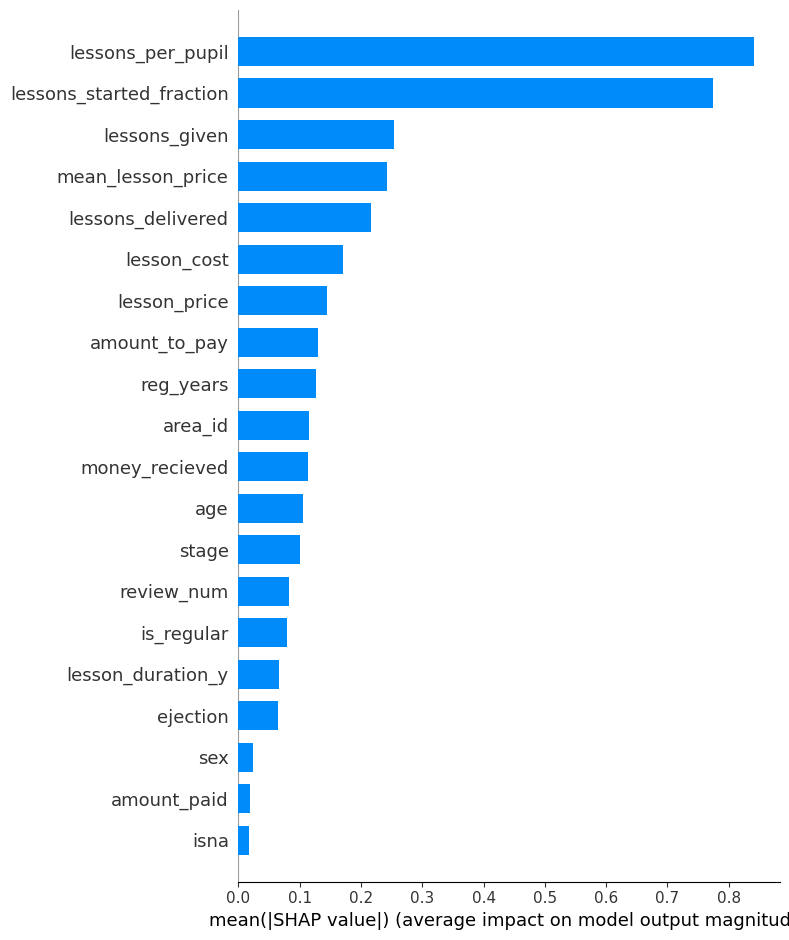

In [45]:
#Инициализируем explainer 
explainer = shap.TreeExplainer(smodel)
#Удаляем модель, которую мы обучали для экспллейнера

#Считаем explaine (это может занять порядка 5-10 минут)
shap_values = explainer(X_train)
#Выведем график важности признаков
shap.summary_plot(shap_values, X_train, plot_type='bar')


На графике выше представлены самые значимые признаки в порядке убывания. Заметим, что значимыми являются и синтетические признаки, такие как isna и ejection.

Далее мы отберём те признаки, которые скажутся лучше всего непосредственно на качестве модели. Для этого мы будем удалять самые малозначимые признаки, обучать модель занового и так далее.

In [46]:
#Для начала, нам надо вытащить числовые знаяения важности признаков. К сожалению, это делается не очень просто или мы не нашли простого способа
feature_names = shap_values.feature_names
shap_df = pd.DataFrame(shap_values.values, columns=feature_names)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(feature_names, vals)), columns=['col_name', 'feature_importance_vals'])
#Сортируем наш список признаков так, чтобы наверху были самые важные 
shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
#Перобразем в список
shap_importance = shap_importance.reset_index(drop = True)
features = list(shap_importance['col_name'])


['lessons_per_pupil',
 'lessons_started_fraction',
 'lessons_given',
 'mean_lesson_price',
 'lessons_delivered',
 'lesson_cost',
 'lesson_price',
 'amount_to_pay',
 'reg_years',
 'area_id',
 'money_recieved',
 'age',
 'stage',
 'review_num',
 'is_regular',
 'lesson_duration_y',
 'ejection',
 'sex',
 'amount_paid',
 'isna',
 'lesson_duration_x',
 'lesson_duration_x__mean_target',
 'isna__mean_target',
 'few_lessons',
 'is_cell_phone_confirmed',
 'is_email_confirmed',
 'is_display',
 'is_pupils_needed',
 'is_pupils_needed__mean_target']

Теперь переберём разные наборы признаков чтобы выбрать лучший набор.

In [47]:
#Инциализируем переменную для лучших признаков и лучшего показателя roc_auc
best_f1_score = 0
best_features = []

#Делим уже обучающую выборку на новую обучающую и валидационную
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Перебираем признаки
for i in tqdm(range(1,len(features))):
    
    model = RandomForestClassifier(**p)
    #Оставляем признаки от нуля (самый важный) до минус шаг итерации (т.е. убираем признаки с конца списка)
    actual_features = features[0:-i]
    #Отбираем данные только с нужными признакми
    X_train_sample = X_train_[actual_features]
    X_val_sample = X_val[actual_features]
    
    #Создаём новую модель. В ней также меняем некоторые параметры, чтобы процесс не был слишком долгим
    model_temp = model
    model_temp.fit(X_train_sample, y_train_)
    pred = model_temp.predict(X_val_sample)
    #Считаем метрику
    actual_f1_score = f1_score(y_val, pred)
    
    #Если метрика лучше той, что до этого была лучшей, то обновляем метрику и список признаков
    if actual_f1_score > best_f1_score:
        best_f1_score = actual_f1_score
        best_features = actual_features
    
    #Удаляем временную модель
    del model_temp

#Выведем те признаки, которые оказались лишними
set(features) - set(best_features)

  0%|          | 0/28 [00:00<?, ?it/s]

{'age',
 'amount_paid',
 'amount_to_pay',
 'area_id',
 'ejection',
 'few_lessons',
 'is_cell_phone_confirmed',
 'is_display',
 'is_email_confirmed',
 'is_pupils_needed',
 'is_pupils_needed__mean_target',
 'is_regular',
 'isna',
 'isna__mean_target',
 'lesson_duration_x',
 'lesson_duration_x__mean_target',
 'lesson_duration_y',
 'lesson_price',
 'money_recieved',
 'reg_years',
 'review_num',
 'sex',
 'stage'}

Выше представлен список тех признаков, которые оказались лишними. Теперь обучим модель на новом датасете, из которого убраны лишние признаки.

In [50]:
model_final = RandomForestClassifier(**p)
model_final.fit(X_train[best_features], y_train)
pred = model_final.predict(X_test[best_features])

scoring()

f1 0.631578947368421
accuracy 0.6976744186046512
recall_score 0.7222222222222222
precision_score 0.5611510791366906
roc_auc_score 0.7030800230282096


## Вывод

Мы исследовали датасеты и объединили их. Мы обработали датасет. В финальный датасет вошли не все данные, так как практика показала, что некоторые данные только ухудшают результат. Также мы использовали разные методы для создания искуственных признаков. От некоторых их методов пришлось отказаться, так как они ухудшали результат. 

Было обучено несколько моделей, но было принято решение остановиться на моделе Случайного Леса. Затем, с помощью модуля shap была выстроена иерархия важности признаков. Методом перебора был выявлен оптимальный набор признаков, который позволил получить наилучшие результаты.

В конце концов, мы добились результата 0.63 для метрики f1 и 0.70 для RocAuc